In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import statsmodels.api as sm
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_excel('data/Loan Book Nov-16.xlsx')
df['count'] = 1

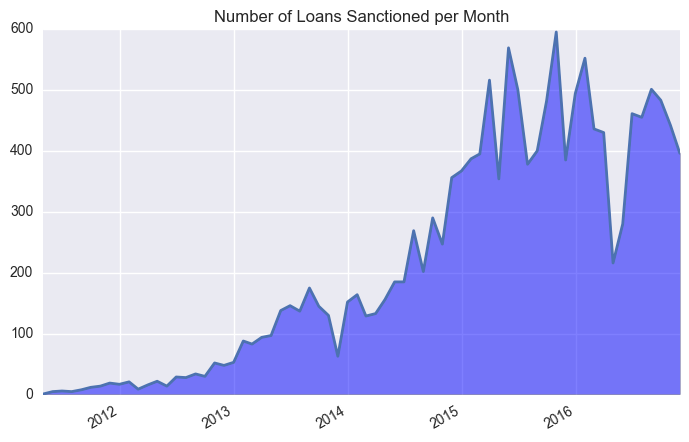

In [3]:
new_df = df.set_index(['San Date']).resample('M').apply(np.sum).reset_index()[['San Date','count']]

fig, ax = plt.subplots(figsize=(7,4.5))
ax.plot(new_df['San Date'], new_df['count'], lw = 2)
plt.title('Number of Loans Sanctioned per Month')
ax.fill_between(new_df['San Date'].values, new_df['count'].min(), 
                new_df['count'], facecolor='blue', alpha=0.5)
fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('Shubham volume of business overtime')
plt.show()

### A challenge with forecasting this time series is the event that occurs in the first half of 2016
### The downward trend at the end indicates that this event has repercussions going into the 2nd half of 2016 as well
### This one time event will unnecessarily bias our forecast, so we need a way to get around this problem
### As the event occurs between end of March '16 and start of June '16, for the initial analysis we'll ignore this event and only forecast till end of March '16

In [4]:
# Ignoring the event for initial analysis
analysis_end_date = '2016-03-31'
new_df = new_df[new_df['San Date'] < analysis_end_date]
new_df = new_df.set_index(['San Date']).resample('M').apply(np.sum)

In [5]:
def plot_tsa(y, lags = 1):
    fig = plt.figure(figsize = (14, 8))
    layout = (2, 2)
    
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax = ts_ax)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    
    plt.tight_layout()

    return ts_ax, acf_ax, pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x10fea9190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x117027c90>)

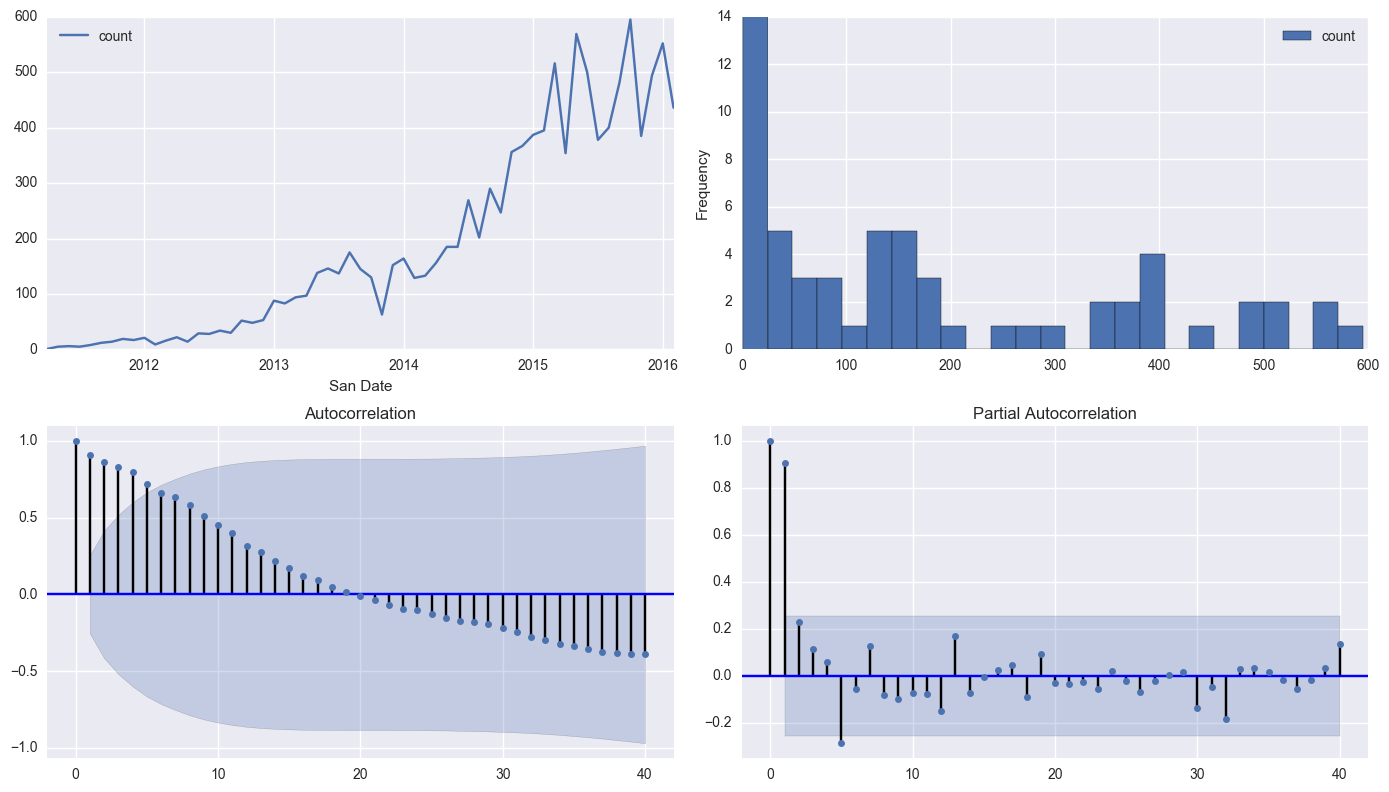

In [6]:
# We seek to understand the time dependency structure of our data
plot_tsa(new_df, lags = 40)

(<matplotlib.axes._subplots.AxesSubplot at 0x117bbbb50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x117d2afd0>)

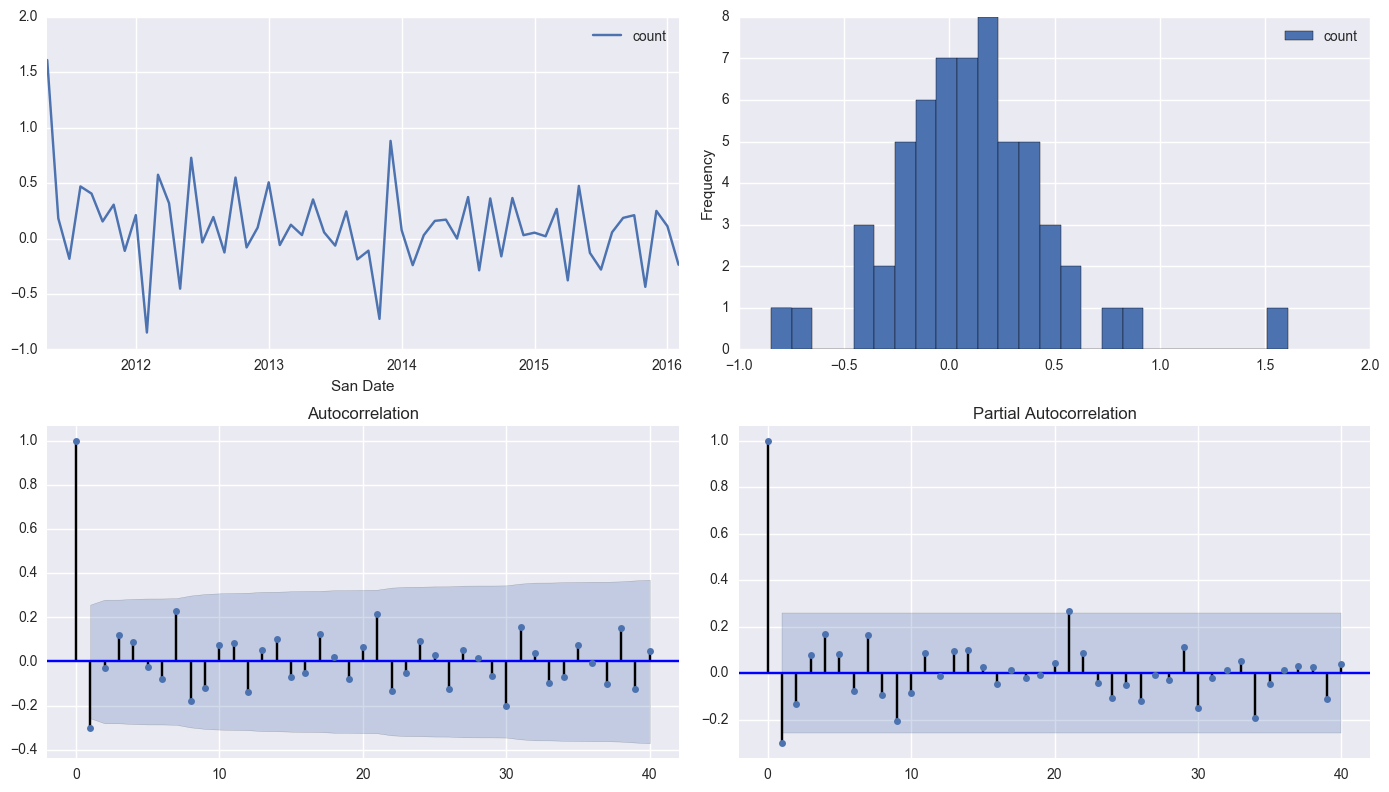

In [7]:
# We'll attempt to make our data stationary and see the correlation graphs
stationary_df = np.log(new_df)
stationary_df = stationary_df.diff()
stationary_df = stationary_df.dropna()

plot_tsa(stationary_df, lags = 40)

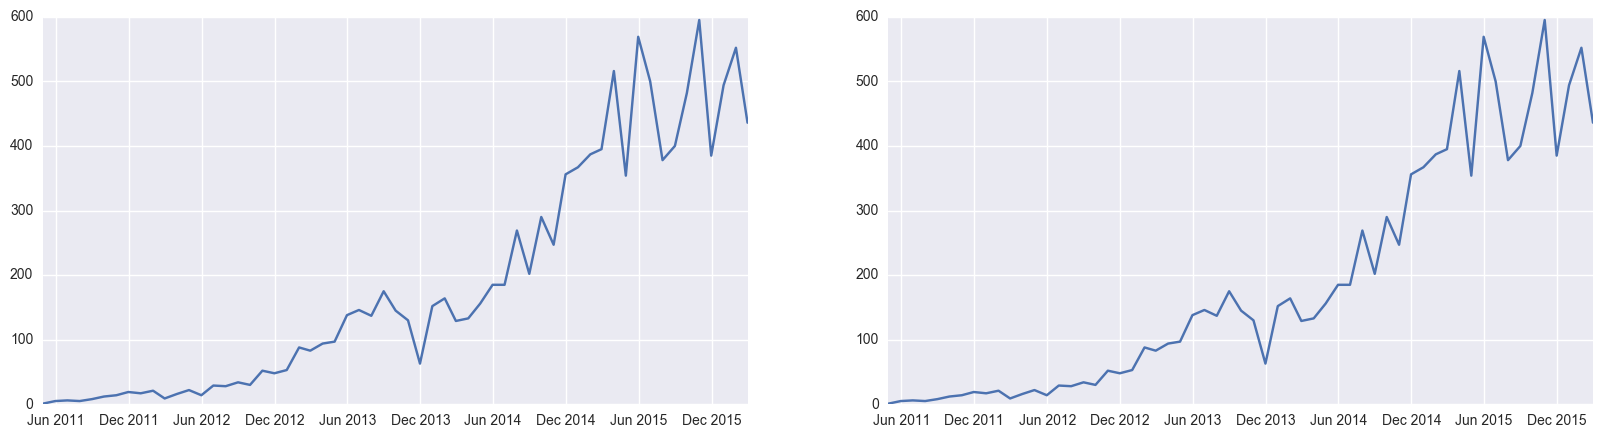

In [8]:
# Making sure the transformations are reversable
fig = plt.figure(figsize = (20, 5))
layout = (1, 2)
ax1   = plt.subplot2grid(layout, (0, 0))
ax2 = plt.subplot2grid(layout, (0, 1))

ax1.plot(np.e**(np.log(new_df)))
ax2.plot(new_df)

In [9]:
y = stationary_df['count']
model = sm.tsa.ARIMA(endog = y, order=[0,1,1])
arima_fit = model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.count   No. Observations:                   57
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -26.163
Method:                       css-mle   S.D. of innovations              0.370
Date:                Sat, 04 Feb 2017   AIC                             58.325
Time:                        23:17:03   BIC                             64.455
Sample:                    06-30-2011   HQIC                            60.707
                         - 02-29-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0052      0.003     -1.799      0.078      -0.011       0.000
ma.L1.D.count    -0.9999      0.049    -20.292      0.000      -1.097      -0.903
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [10]:
# Addressing the seasonal component of the data via Sarimax
y = stationary_df['count']
model = sm.tsa.statespace.SARIMAX(endog = y, order=(0,0,2), 
                                seasonal_order=(0,0,0,12), simple_differencing=True)
sarima_fit = model.fit()
print(sarima_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                  count   No. Observations:                   58
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 -24.550
Date:                Sat, 04 Feb 2017   AIC                             55.099
Time:                        23:17:03   BIC                             61.281
Sample:                    05-31-2011   HQIC                            57.507
                         - 02-29-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5382      0.103     -5.220      0.000      -0.740      -0.336
ma.L2          0.3288      0.124      2.644      0.008       0.085       0.573
sigma2         0.1356      0.017      8.008      0.0

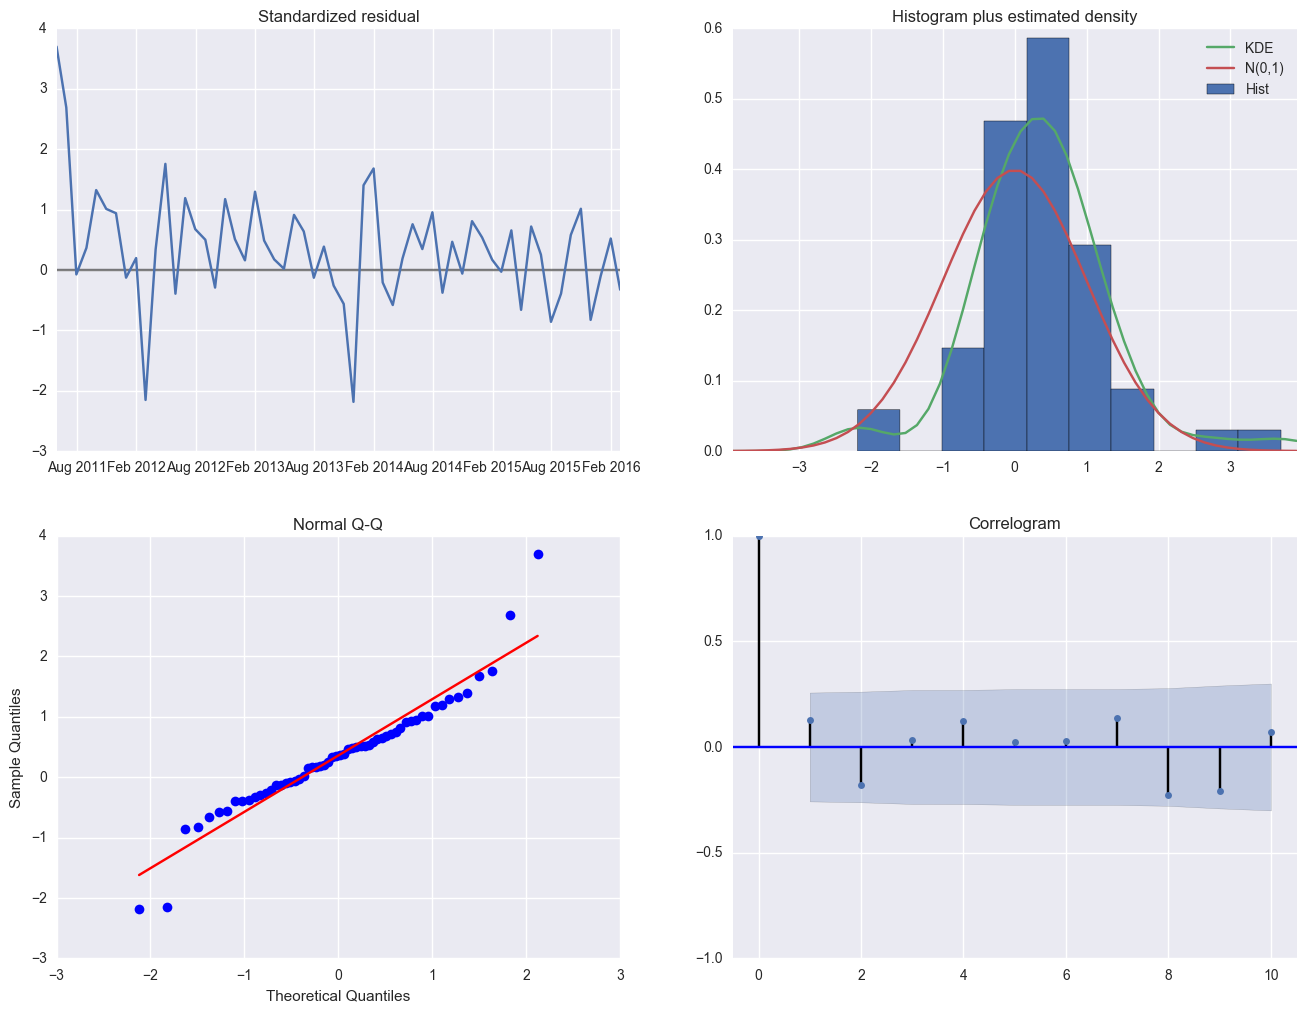

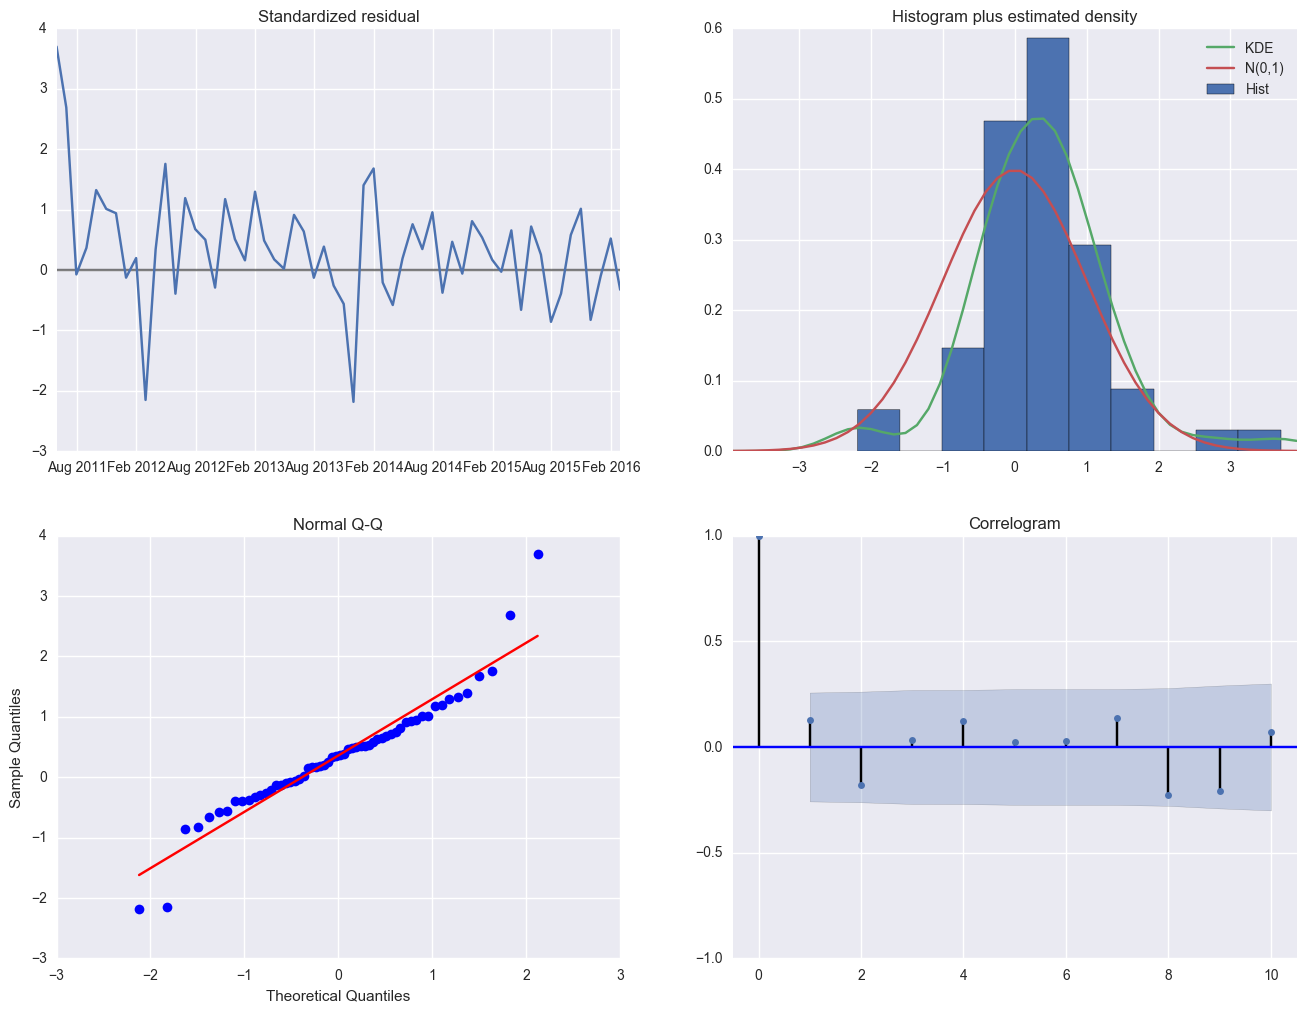

In [11]:
# Check whether the Standardized residuals look like white noise
sarima_fit.plot_diagnostics(figsize=(16, 12))

In [12]:
def plot_final_fit(df, training_percentage, order):
    n_sample = df.shape[0]

    n_train = int(training_percentage * n_sample) + 1
    n_forecast = n_sample - n_train

    series_train = np.e**(df).iloc[:n_train]['count']
    series_test  = np.e**(df).iloc[n_train:]['count']

    model = sm.tsa.statespace.SARIMAX(series_train, order = order, seasonal_order=(0,0,0,12), 
                                       enforce_invertibility = False)
    fit = model.fit()

    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 8))

    ax.plot(series_train, label='In-sample data', linestyle = '-')
    ax.plot(series_test, label='out-sample data', linestyle = '--')

    pred_begin = series_train.index[fit.loglikelihood_burn]
    pred_end = series_test.index[-1]
    pred = fit.get_prediction(start = pred_begin.to_datetime().strftime('%Y-%m-%d'),
                                        end = pred_end.strftime('%Y-%m-%d'))
    pred_mean = pred.predicted_mean
    # 95% confidence intervals
    pred_ci = pred.conf_int(alpha = 0.05)

    ax.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
    ax.fill_between(pred_ci.index,
                     pred_ci.iloc[:, 0],
                     pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.legend(loc='best')
    
    return fit

/Users/namanjain/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(58, 1)

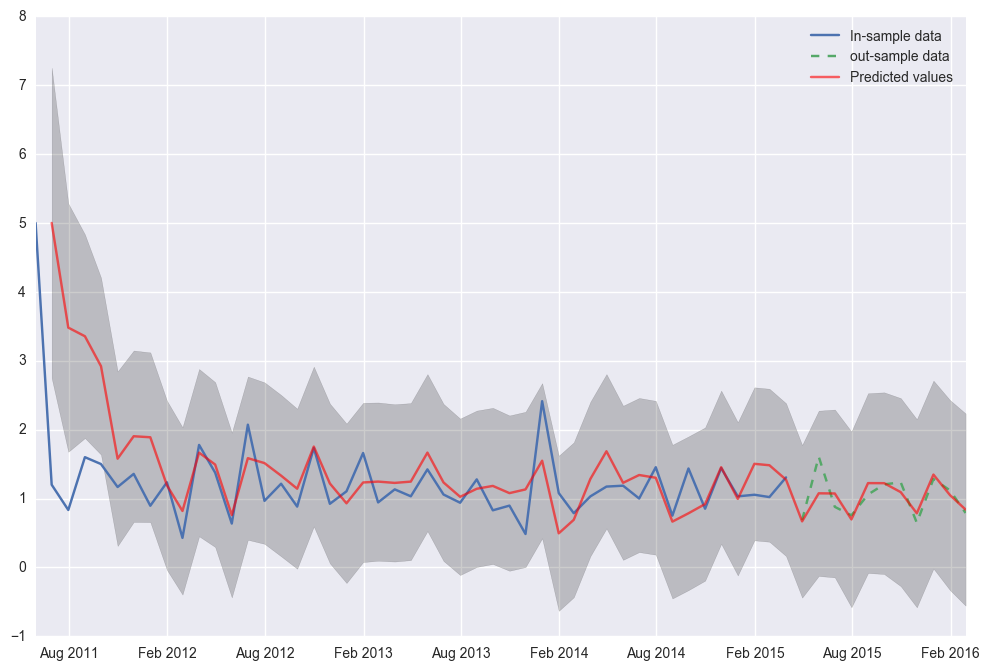

In [13]:
# I was reluctant on using an order with 14 degrees of freedom as there are only 
# 58 observations, but this model seems to perform the best
fitted_model = plot_final_fit(stationary_df, training_percentage = 0.8, order = (6,1,7))
stationary_df.shape

### We can see our model does a pretty good job of forecasting for the 20% out sample data. 
### Now, we can use this model to predict for the duration of the event, and replace the original data with our prediction. 
### This will allow our forecasting to not get unnecessarily biased by a one time event

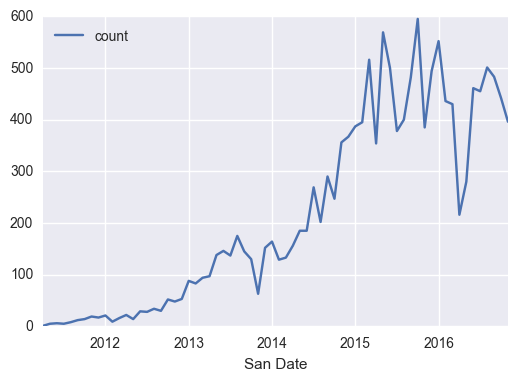

In [14]:
# Orignial data
final_df = df.copy()
final_df['count'] = 1
final_df = pd.DataFrame(final_df.set_index(['San Date']).resample('M').apply(np.sum)['count'])
final_df.plot()

/Users/namanjain/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


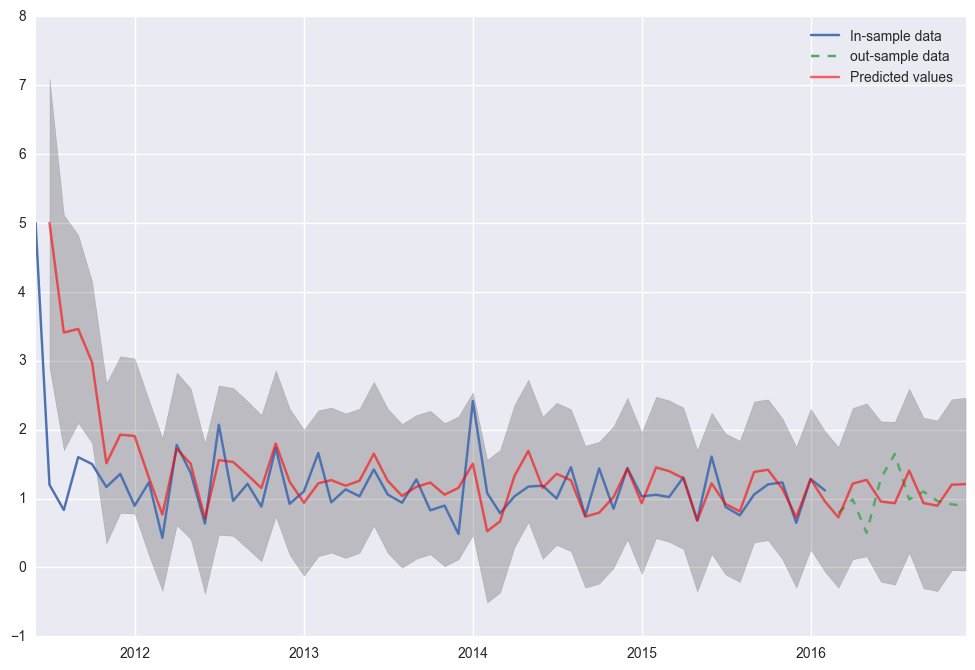

In [15]:
# Fitting the Sarimax model on the entire time series
final_stationary_df = np.log(final_df)
final_stationary_df = final_stationary_df.diff()
final_stationary_df = final_stationary_df.dropna()

fitted_model = plot_final_fit(final_stationary_df, training_percentage = 0.85, order = (6,1,7))

### As expected, the out-sample forecast during the event is way of target
### We'll replace the values during the event by the predicted values from the fitted Sarimax model

In [16]:
# https://github.com/statsmodels/statsmodels/issues/2553
indices = [datetime(2016, 4, 30), datetime(2016, 5, 31), datetime(2016, 6, 30)]
values = np.log(fitted_model.predict(0, 70)).diff()[indices]

for i, indice in enumerate(indices):
    final_stationary_df.ix[indice] = values[i]

/Users/namanjain/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/base/model.py:475: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


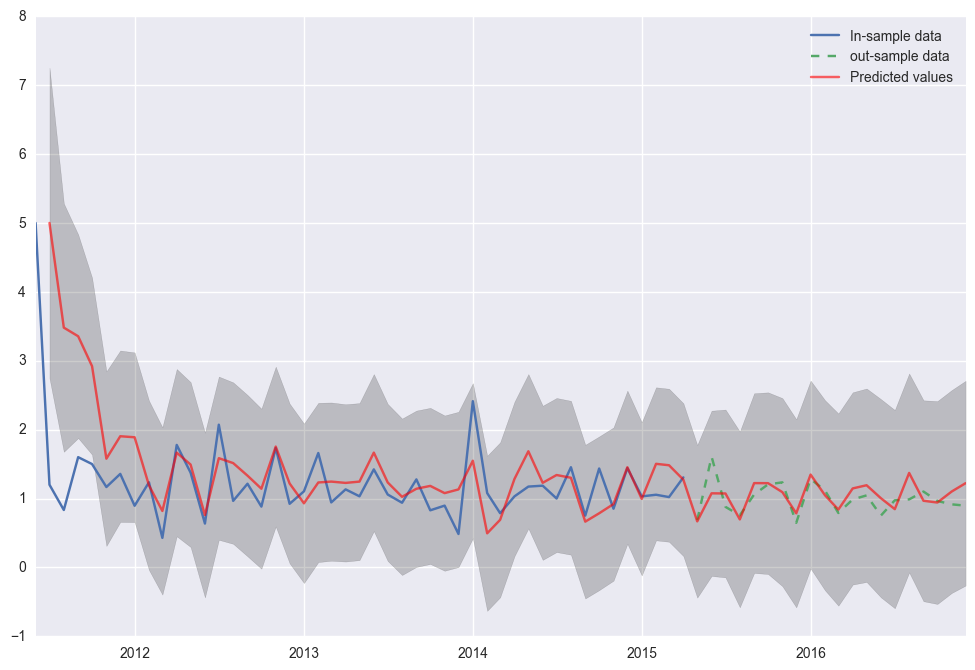

In [17]:
fitted_model = plot_final_fit(final_stationary_df, training_percentage = 0.70, order = (6,1,7))

### Here we see our model does a pretty good job of forecasting 30% of the time series after the event is dealt with

References:
- http://www.statsmodels.org/dev/tsa.html
- https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
- http://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
- http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
- http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html